## Evaluation results for 4 users in a classroom with 20 steps of DRL agent per location

In [29]:
import torch
import numpy as np
import matplotlib.pyplot as plt


In [30]:
results = torch.load('/home/hieule/research/rs/local_assets/ppo_classroom_4ue/models/env_rollout_images_classroom_4ue.pt',
                     weights_only=False)

In [31]:
results

TensorDict(
    fields={
        agents: TensorDict(
            fields={
                action: Tensor(shape=torch.Size([5, 1, 400, 4, 3]), device=cuda:0, dtype=torch.float32, is_shared=True),
                action_log_prob: Tensor(shape=torch.Size([5, 1, 400, 4]), device=cuda:0, dtype=torch.float32, is_shared=True),
                cur_rss: Tensor(shape=torch.Size([5, 1, 400, 4, 4]), device=cuda:0, dtype=torch.float32, is_shared=True),
                episode_reward: Tensor(shape=torch.Size([5, 1, 400, 4, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
                focals: Tensor(shape=torch.Size([5, 1, 400, 4, 3]), device=cuda:0, dtype=torch.float32, is_shared=True),
                loc: Tensor(shape=torch.Size([5, 1, 400, 4, 3]), device=cuda:0, dtype=torch.float32, is_shared=True),
                observation: Tensor(shape=torch.Size([5, 1, 400, 4, 9]), device=cuda:0, dtype=torch.float32, is_shared=True),
                prev_rss: Tensor(shape=torch.Size([5, 1, 400, 

In [32]:
cur_rss = results['agents', 'cur_rss'].cpu()
cur_rss.shape

torch.Size([5, 1, 400, 4, 4])

In [33]:
rfs = [cur_rss[..., i:i+1, i:i+1] for i in range(cur_rss.shape[-1])]
rfs = torch.cat(rfs, dim=-2) - 39

In [34]:
rfs.shape

torch.Size([5, 1, 400, 4, 1])

## Sum RSSI of all users with different seeds

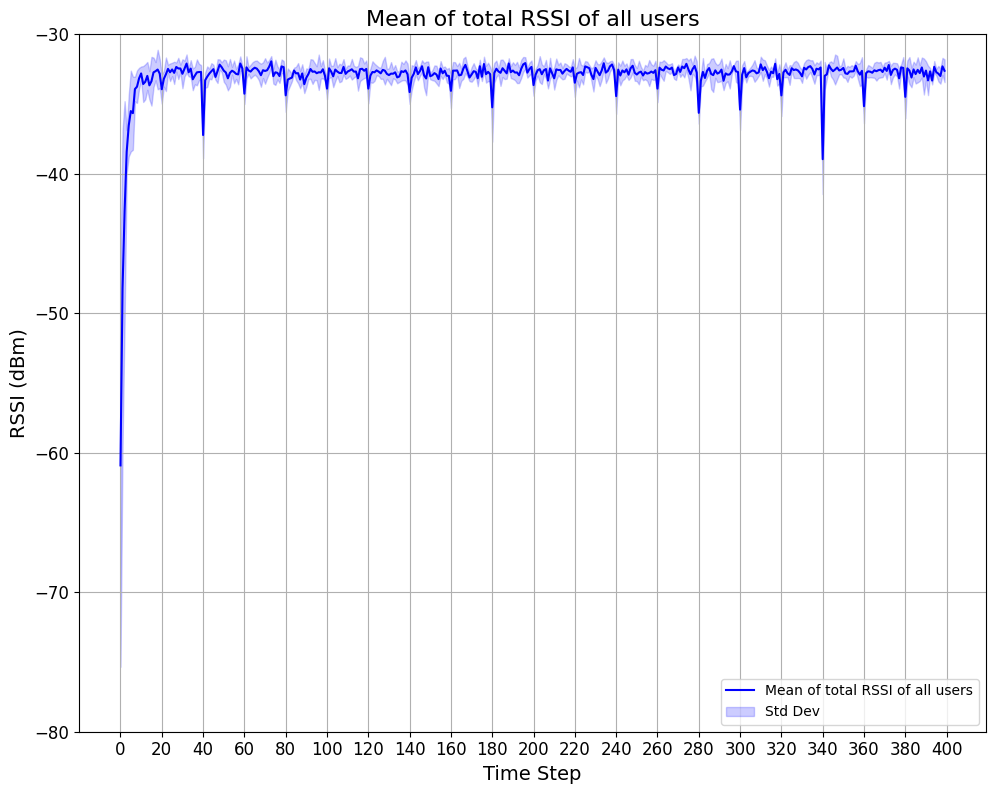

In [46]:
rfs_sum = 10 ** (rfs / 10)  # Convert dBm to linear scale
rfs_sum = rfs_sum[..., 0].sum(dim=-1)
rfs_sum = 10 * torch.log10(rfs_sum)  # Convert back to dBm
rfs_sum.shape
rfs_sum = rfs_sum[1:, ...]
all_rfs_sum = rfs_sum.mean(dim=0)[0]
all_rfs_std = rfs_sum.std(dim=0)[0]
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(all_rfs_sum, label='Mean of total RSSI of all users', color='blue')
ax.fill_between(range(len(all_rfs_sum)), 
                all_rfs_sum - all_rfs_std, 
                all_rfs_sum + all_rfs_std, 
                color='blue', alpha=0.2, label='Std Dev')
ax.set_title('Mean of total RSSI of all users', fontsize=16)
ax.set_xlabel('Time Step',  fontsize=14)
ax.set_ylabel('RSSI (dBm)',  fontsize=14)
ax.legend(loc='lower right')
plt.tight_layout()
ax.grid(True)
ax.xaxis.set_major_locator(plt.MultipleLocator(20))
ax.set_ylim(-80, -30)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)

## Mean RSSI of all users with different seeds

rfs_mean shape: torch.Size([4, 1, 400])
all_rfs_mean shape: torch.Size([400])
all_rfs_std shape: torch.Size([400])


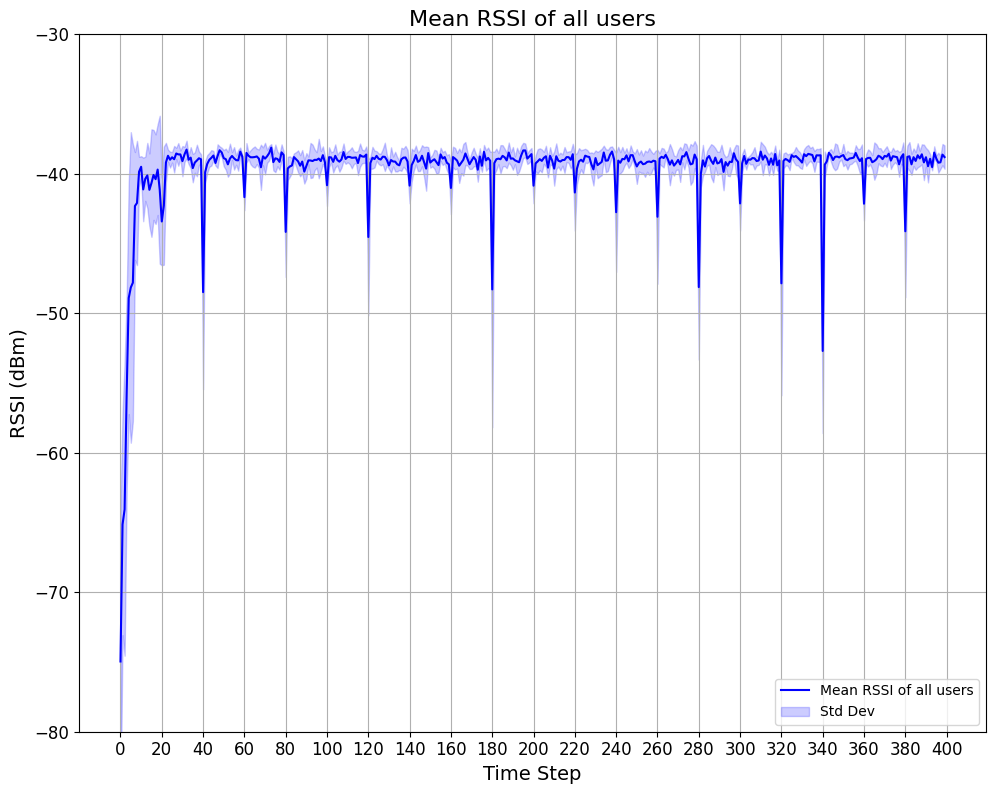

In [47]:
rfs_mean = rfs[..., 0].mean(dim=-1)
rfs_mean.shape
rfs_mean = rfs_mean[1:, ...]
print(f"rfs_mean shape: {rfs_mean.shape}")
all_rfs_mean = rfs_mean.mean(dim=0)[0]
all_rfs_std = rfs_mean.std(dim=0)[0]
print(f"all_rfs_mean shape: {all_rfs_mean.shape}")
print(f"all_rfs_std shape: {all_rfs_std.shape}")
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(all_rfs_mean, label='Mean RSSI of all users', color='blue')
ax.fill_between(range(len(all_rfs_mean)), 
                all_rfs_mean - all_rfs_std, 
                all_rfs_mean + all_rfs_std, 
                color='blue', alpha=0.2, label='Std Dev')
ax.set_title('Mean RSSI of all users', fontsize=16)
ax.set_xlabel('Time Step', fontsize=14)
ax.set_ylabel('RSSI (dBm)', fontsize=14)
ax.legend(loc='lower right')
plt.tight_layout()
ax.grid(True)
ax.xaxis.set_major_locator(plt.MultipleLocator(20))
ax.set_ylim(-80, -30)
# set font size of x and y labels
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)

In [37]:
def smooth(data, window_size=5):
    """Smooth the data using a Gaussian moving average filter."""
    # first, pad the data with zeros
    pad_size = window_size + 3
    data = np.pad(data, (pad_size, pad_size), mode="edge")
    # then, apply the Gaussian moving average filter
    kernel = np.exp(-0.5 * (np.arange(-pad_size, pad_size + 1) / 1) ** 2)
    kernel /= np.sum(kernel)
    smoothed_data = np.convolve(data, kernel, mode="same")
    # remove the padding
    smoothed_data = smoothed_data[pad_size:-pad_size]
    return smoothed_data

rfs_mean_smooth shape: (4, 400)
all_rfs_mean shape: (400,)
all_rfs_std shape: (400,)


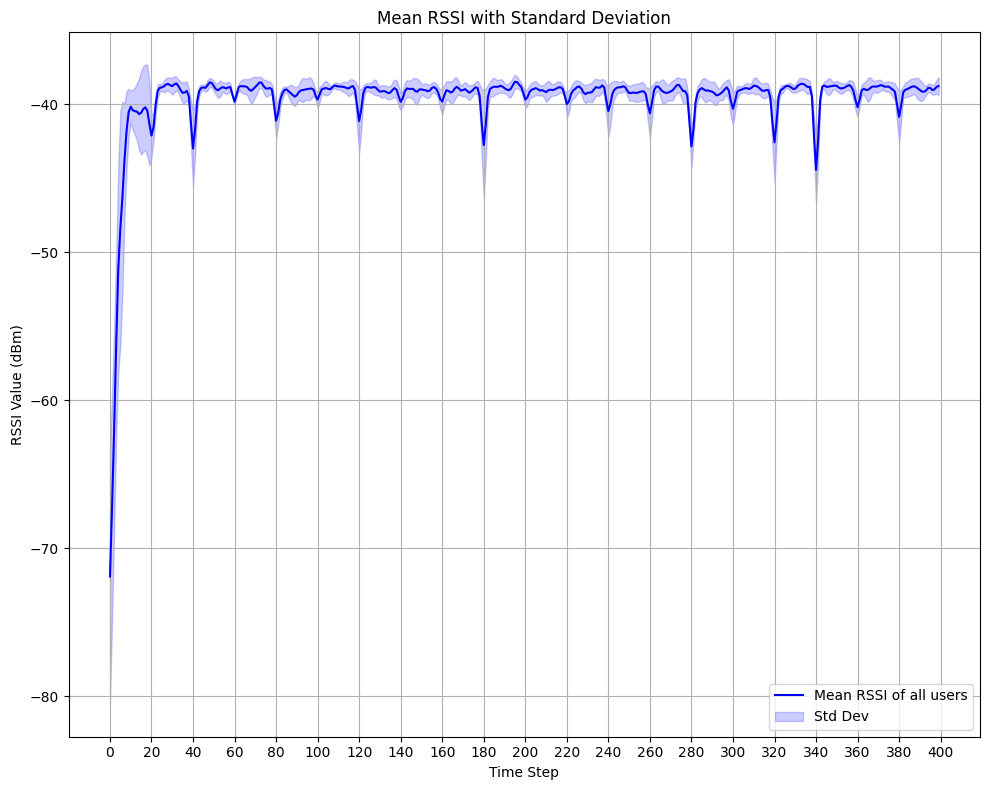

In [38]:
# smooth rfs_mean using moving average
rfs_mean_smooth = rfs_mean.clone()
rfs_mean_smooth = [smooth(rfs_mean_smooth[i, 0, :].numpy(), window_size=2) for i in range(rfs_mean_smooth.shape[0])]
rfs_mean_smooth = np.array(rfs_mean_smooth)
print(f"rfs_mean_smooth shape: {rfs_mean_smooth.shape}")
all_rfs_mean = rfs_mean_smooth.mean(axis=0)
all_rfs_std = rfs_mean_smooth.std(axis=0)
print(f"all_rfs_mean shape: {all_rfs_mean.shape}")
print(f"all_rfs_std shape: {all_rfs_std.shape}")
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(all_rfs_mean, label='Mean RSSI of all users', color='blue')
ax.fill_between(range(len(all_rfs_mean)), 
                all_rfs_mean - all_rfs_std, 
                all_rfs_mean + all_rfs_std, 
                color='blue', alpha=0.2, label='Std Dev')
ax.set_title('Mean RSSI with Standard Deviation')
ax.set_xlabel('Time Step')
ax.set_ylabel('RSSI Value (dBm)')
ax.legend()
plt.tight_layout()
ax.grid(True)
ax.xaxis.set_major_locator(plt.MultipleLocator(20))

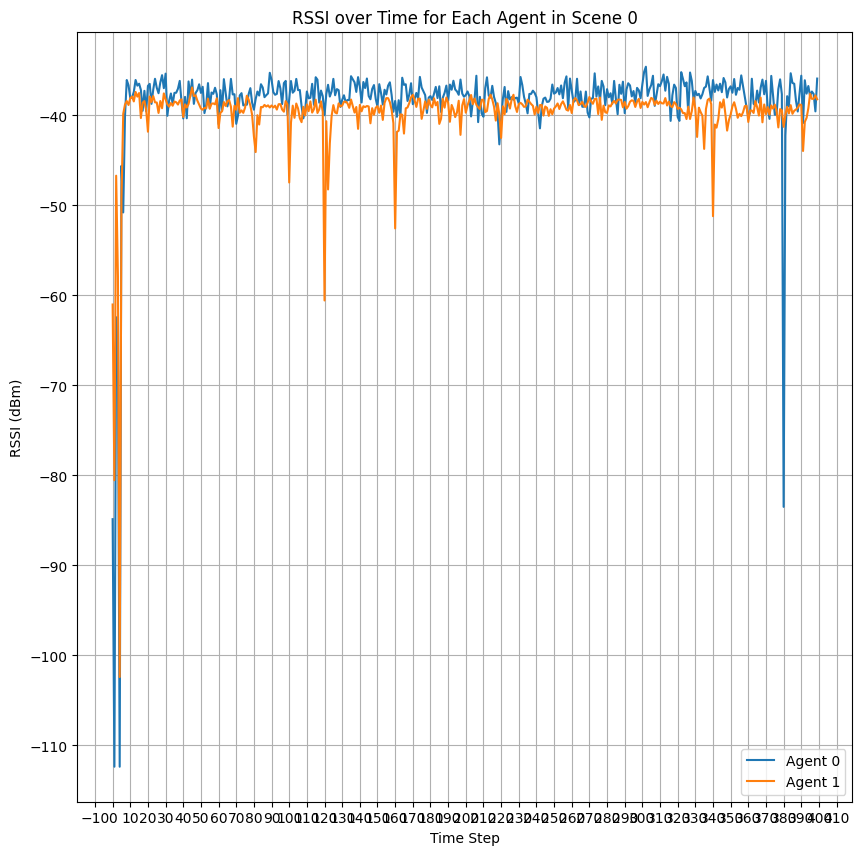

In [39]:
scene0 = rfs[0, 0]
scene0.shape
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(scene0[:, 0, 0].numpy(), label='Agent 0')
ax.plot(scene0[:, 1, 0].numpy(), label='Agent 1')
ax.legend()
ax.set_xlabel('Time Step')
ax.set_ylabel('RSSI (dBm)')
ax.set_title('RSSI over Time for Each Agent in Scene 0')
ax.grid(True)
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
plt.show()

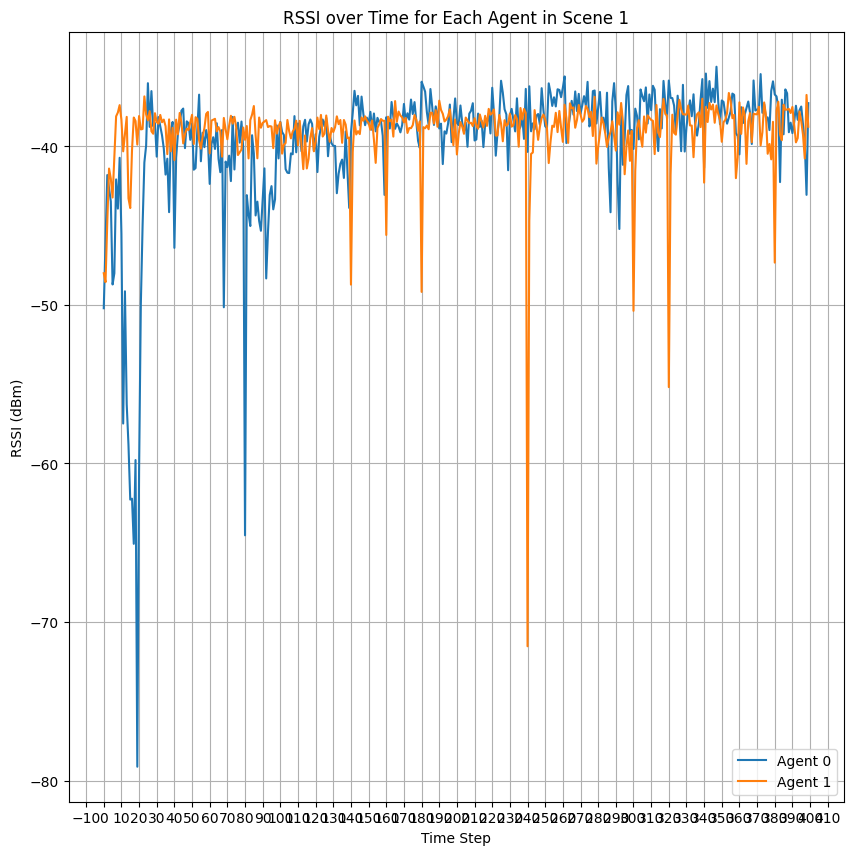

In [40]:
scene1 = rfs[1, 0]
scene1.shape
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(scene1[:, 0, 0].numpy(), label='Agent 0')
ax.plot(scene1[:, 1, 0].numpy(), label='Agent 1')
ax.legend()
ax.set_xlabel('Time Step')
ax.set_ylabel('RSSI (dBm)')
ax.set_title('RSSI over Time for Each Agent in Scene 1')
ax.grid(True)
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
plt.show()

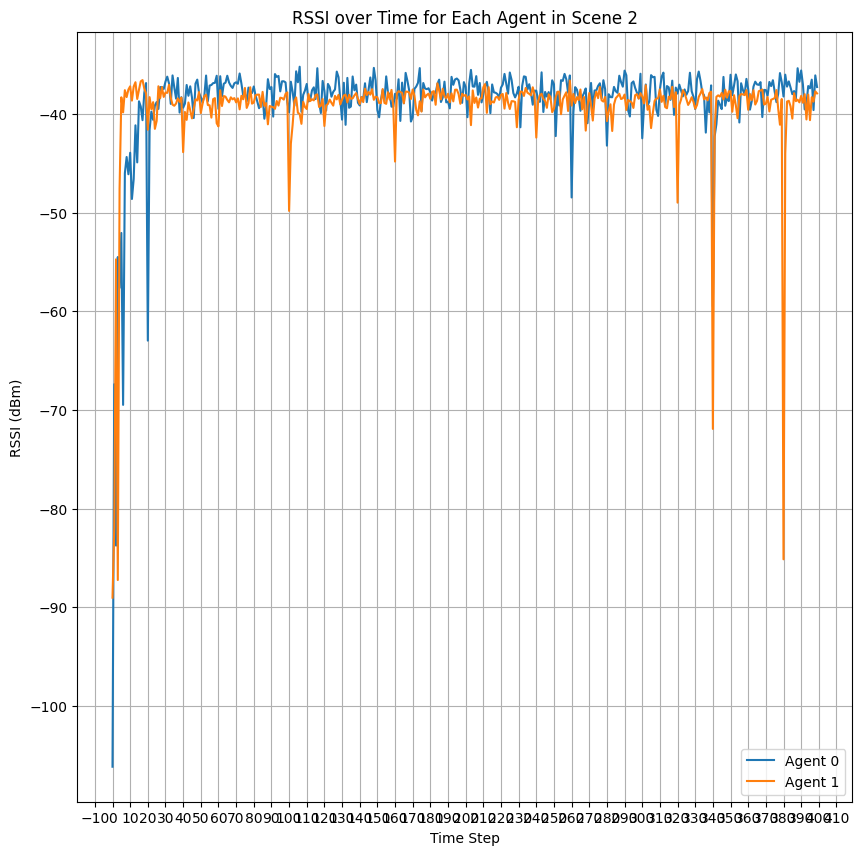

In [41]:
scene2 = rfs[2, 0]
scene2.shape
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(scene2[:, 0, 0].numpy(), label='Agent 0')
ax.plot(scene2[:, 1, 0].numpy(), label='Agent 1')
ax.legend()
ax.set_xlabel('Time Step')
ax.set_ylabel('RSSI (dBm)')
ax.set_title('RSSI over Time for Each Agent in Scene 2')
ax.grid(True)
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
plt.show()